# MEMTO Tutorial for Anomaly Detection
This notebook demonstrates how to use MEMTO for time series anomaly detection

## 1. Packages import and prepare arguments

In [1]:

import os
import time

import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from tsadlib.metrics.adjustment import point_adjustment

from tsadlib.configs.constants import LIBRARY_ROOT
from tsadlib.configs.log_config import log
from tsadlib.configs.type import ConfigType
from tsadlib.data_provider.data_factory import data_provider
from tsadlib.metrics.threshold import percentile_threshold
from tsadlib.models.memto import MEMTO
from tsadlib.utils.clustering import k_means_clustering
from tsadlib.utils.loss import EntropyLoss, GatheringLoss
from tsadlib.utils.traning_stoper import OneEarlyStopping

# Set up device for computation (CUDA GPU, Apple M1/M2 GPU, or CPU)
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

log.info(f'use device: {device}')
device = torch.device(device)

# Define paths for dataset and model checkpoints
# DATASET_ROOT = 'E:\\liuzhenzhou\\datasets'
# DATASET_ROOT = '/Users/liuzhenzhou/Documents/backup/datasets/anomaly_detection/npy'
DATASET_ROOT = '/home/lzz/Desktop/datasets'
DATASET_TYPE = 'MSL'  # Mars Science Laboratory dataset
MODEL = 'MEMTO'
CHECKPOINTS = os.path.join(LIBRARY_ROOT, 'checkpoints', MODEL)

writer = SummaryWriter(os.path.join(LIBRARY_ROOT, 'runs', MODEL).__str__())

# Configure TimesNet hyperparameters and training settings
args = ConfigType(**{
    'model': MODEL,
    'mode': 'train',
    'dataset_root_path': os.path.join(DATASET_ROOT, DATASET_TYPE),
    'window_size': 100,
    'batch_size': 256,
    'd_model': 8,
    'dimension_fcl': 16,
    'encoder_layers': 3,
    'input_channels': 55,
    'output_channels': 55,
    'num_memory': 10,
    'hyper_parameter_lambda': 0.01,
    'dropout': 0.1,
    'anomaly_ratio': 1,
    'num_epochs': 100,
    'learning_rate': 1e-4
})

# Load training and testing data
train_loader, validate_loader, test_loader, k_loader = data_provider(args, split_way='train_validate_k_split')

2025-03-29 18:39:58.152 | __main__:<module>:30 | INFO: use device: cuda:0


## 2. Model definition and training

### 2.1 First Training for optimize encoder

In [2]:
# Initialize model and training components
model = MEMTO(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = nn.MSELoss()
entropy_criterion = EntropyLoss()
early_stopping = OneEarlyStopping(args.patience, CHECKPOINTS, DATASET_TYPE)
train_steps = len(train_loader)
log.info('The first phase training starts')

for epoch in range(args.num_epochs):
    model.train()
    train_losses = []
    reconstruct_losses = []
    entropy_losses = []
    validate_losses = []
    iter_count = 0
    epoch_time = time.time()

    model.train()
    for i, (x_data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1} / {args.num_epochs}')):
        iter_count += 1
        optimizer.zero_grad()
        x_data = x_data.float().to(device)

        # Forward pass
        output_dict = model(x_data)
        output, attention = output_dict['output'], output_dict['attention']
        reconstruct_loss = criterion(output, x_data)
        entropy_loss = entropy_criterion(attention)
        loss = reconstruct_loss + args.hyper_parameter_lambda * entropy_loss

        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/Train', loss.item(), epoch * train_steps + i)
            writer.add_scalar('Loss/Reconstruct', reconstruct_loss.item(), epoch * train_steps + i)
            writer.add_scalar('Loss/Entropy', entropy_loss.item(), epoch * train_steps + i)

        # Backward pass
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        reconstruct_losses.append(reconstruct_loss.item())
        entropy_losses.append(entropy_loss)

    model.eval()
    with torch.no_grad():
        for i, (x_data, _) in enumerate(validate_loader):
            x_data = x_data.float().to(device)
            # Forward pass
            output_dict = model(x_data)
            output, attention = output_dict['output'], output_dict['attention']
            reconstruct_loss = criterion(output, x_data)
            entropy_loss = entropy_criterion(attention)
            loss = reconstruct_loss + args.hyper_parameter_lambda * entropy_loss
            validate_losses.append(loss.item())

    train_avg_loss = np.average(train_losses)
    validate_avg_loss = np.average(validate_losses)
    log.info("Epoch: {:>2} cost time: {:<10.4f}s, train loss: {:<.7f}, validate loss: {:<.7f}", epoch + 1,
             time.time() - epoch_time, train_avg_loss, validate_avg_loss)

    writer.add_scalars("Loss", {"Train": train_avg_loss, "Validation": validate_avg_loss}, epoch)

    # Early stopping check
    early_stopping(validate_avg_loss, model)
    if early_stopping.early_stop:
        log.warning("Early stopping triggered")
        break

2025-03-29 18:39:58.647 | tsadlib.layers.memory_layer:__init__:78 | INFO: loading memory item with random initialization (for first train phase)
2025-03-29 18:39:59.444 | __main__:<module>:8 | INFO: The first phase training starts


Epoch 1 / 100: 100%|██████████| 181/181 [00:06<00:00, 28.03it/s]


2025-03-29 18:40:06.363 | __main__:<module>:58 | INFO: Epoch:  1 cost time: 6.9181    s, train loss: 0.8398840, validate loss: 0.6926710
2025-03-29 18:40:06.366 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (inf --> 0.692671).  Saving model ...


Epoch 2 / 100: 100%|██████████| 181/181 [00:05<00:00, 32.27it/s]


2025-03-29 18:40:12.452 | __main__:<module>:58 | INFO: Epoch:  2 cost time: 6.0680    s, train loss: 0.7086525, validate loss: 0.6098922
2025-03-29 18:40:12.453 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.692671 --> 0.609892).  Saving model ...


Epoch 3 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.58it/s]


2025-03-29 18:40:18.179 | __main__:<module>:58 | INFO: Epoch:  3 cost time: 5.7075    s, train loss: 0.6585925, validate loss: 0.5812112
2025-03-29 18:40:18.180 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.609892 --> 0.581211).  Saving model ...


Epoch 4 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.27it/s]


2025-03-29 18:40:24.109 | __main__:<module>:58 | INFO: Epoch:  4 cost time: 5.9119    s, train loss: 0.6416343, validate loss: 0.5715920
2025-03-29 18:40:24.110 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.581211 --> 0.571592).  Saving model ...


Epoch 5 / 100: 100%|██████████| 181/181 [00:04<00:00, 43.79it/s]


2025-03-29 18:40:28.724 | __main__:<module>:58 | INFO: Epoch:  5 cost time: 4.5961    s, train loss: 0.6346980, validate loss: 0.5681360
2025-03-29 18:40:28.724 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.571592 --> 0.568136).  Saving model ...


Epoch 6 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.53it/s]


2025-03-29 18:40:34.631 | __main__:<module>:58 | INFO: Epoch:  6 cost time: 5.8879    s, train loss: 0.6300041, validate loss: 0.5639559
2025-03-29 18:40:34.631 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.568136 --> 0.563956).  Saving model ...


Epoch 7 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.65it/s]


2025-03-29 18:40:40.521 | __main__:<module>:58 | INFO: Epoch:  7 cost time: 5.8613    s, train loss: 0.6259098, validate loss: 0.5588730
2025-03-29 18:40:40.521 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.563956 --> 0.558873).  Saving model ...


Epoch 8 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.60it/s]


2025-03-29 18:40:46.410 | __main__:<module>:58 | INFO: Epoch:  8 cost time: 5.8492    s, train loss: 0.6213103, validate loss: 0.5519064
2025-03-29 18:40:46.410 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.558873 --> 0.551906).  Saving model ...


Epoch 9 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.82it/s]


2025-03-29 18:40:52.243 | __main__:<module>:58 | INFO: Epoch:  9 cost time: 5.8146    s, train loss: 0.6152343, validate loss: 0.5432107
2025-03-29 18:40:52.243 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.551906 --> 0.543211).  Saving model ...


Epoch 10 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.36it/s]


2025-03-29 18:40:57.999 | __main__:<module>:58 | INFO: Epoch: 10 cost time: 5.7367    s, train loss: 0.6076914, validate loss: 0.5362255
2025-03-29 18:40:57.999 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.543211 --> 0.536225).  Saving model ...


Epoch 11 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.19it/s]


2025-03-29 18:41:03.982 | __main__:<module>:58 | INFO: Epoch: 11 cost time: 5.9649    s, train loss: 0.6024238, validate loss: 0.5291335
2025-03-29 18:41:03.983 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.536225 --> 0.529133).  Saving model ...


Epoch 12 / 100: 100%|██████████| 181/181 [00:04<00:00, 41.43it/s]


2025-03-29 18:41:08.841 | __main__:<module>:58 | INFO: Epoch: 12 cost time: 4.8366    s, train loss: 0.5949957, validate loss: 0.5217792
2025-03-29 18:41:08.841 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.529133 --> 0.521779).  Saving model ...


Epoch 13 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.16it/s]


2025-03-29 18:41:12.458 | __main__:<module>:58 | INFO: Epoch: 13 cost time: 3.5971    s, train loss: 0.5899018, validate loss: 0.5152680
2025-03-29 18:41:12.458 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.521779 --> 0.515268).  Saving model ...


Epoch 14 / 100: 100%|██████████| 181/181 [00:05<00:00, 32.90it/s]


2025-03-29 18:41:18.449 | __main__:<module>:58 | INFO: Epoch: 14 cost time: 5.9680    s, train loss: 0.5838872, validate loss: 0.5099099
2025-03-29 18:41:18.450 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.515268 --> 0.509910).  Saving model ...


Epoch 15 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.78it/s]


2025-03-29 18:41:24.332 | __main__:<module>:58 | INFO: Epoch: 15 cost time: 5.8513    s, train loss: 0.5780599, validate loss: 0.5024456
2025-03-29 18:41:24.332 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.509910 --> 0.502446).  Saving model ...


Epoch 16 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.70it/s]


2025-03-29 18:41:30.211 | __main__:<module>:58 | INFO: Epoch: 16 cost time: 5.8580    s, train loss: 0.5720642, validate loss: 0.4954514
2025-03-29 18:41:30.212 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.502446 --> 0.495451).  Saving model ...


Epoch 17 / 100: 100%|██████████| 181/181 [00:06<00:00, 29.33it/s]


2025-03-29 18:41:36.920 | __main__:<module>:58 | INFO: Epoch: 17 cost time: 6.6797    s, train loss: 0.5671369, validate loss: 0.4898043
2025-03-29 18:41:36.920 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.495451 --> 0.489804).  Saving model ...


Epoch 18 / 100: 100%|██████████| 181/181 [00:05<00:00, 31.25it/s]


2025-03-29 18:41:43.229 | __main__:<module>:58 | INFO: Epoch: 18 cost time: 6.2816    s, train loss: 0.5612674, validate loss: 0.4830097
2025-03-29 18:41:43.229 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.489804 --> 0.483010).  Saving model ...


Epoch 19 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.26it/s]


2025-03-29 18:41:49.166 | __main__:<module>:58 | INFO: Epoch: 19 cost time: 5.9163    s, train loss: 0.5563133, validate loss: 0.4814906
2025-03-29 18:41:49.167 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.483010 --> 0.481491).  Saving model ...


Epoch 20 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.77it/s]


2025-03-29 18:41:55.026 | __main__:<module>:58 | INFO: Epoch: 20 cost time: 5.8380    s, train loss: 0.5524517, validate loss: 0.4750450
2025-03-29 18:41:55.027 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.481491 --> 0.475045).  Saving model ...


Epoch 21 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.48it/s]


2025-03-29 18:42:00.768 | __main__:<module>:58 | INFO: Epoch: 21 cost time: 5.7214    s, train loss: 0.5469675, validate loss: 0.4697276
2025-03-29 18:42:00.769 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.475045 --> 0.469728).  Saving model ...


Epoch 22 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.99it/s]


2025-03-29 18:42:06.582 | __main__:<module>:58 | INFO: Epoch: 22 cost time: 5.7935    s, train loss: 0.5436901, validate loss: 0.4655495
2025-03-29 18:42:06.582 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.469728 --> 0.465549).  Saving model ...


Epoch 23 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.60it/s]


2025-03-29 18:42:12.497 | __main__:<module>:58 | INFO: Epoch: 23 cost time: 5.8947    s, train loss: 0.5397231, validate loss: 0.4629595
2025-03-29 18:42:12.497 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.465549 --> 0.462960).  Saving model ...


Epoch 24 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.68it/s]


2025-03-29 18:42:18.377 | __main__:<module>:58 | INFO: Epoch: 24 cost time: 5.8616    s, train loss: 0.5368459, validate loss: 0.4590912
2025-03-29 18:42:18.378 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.462960 --> 0.459091).  Saving model ...


Epoch 25 / 100: 100%|██████████| 181/181 [00:05<00:00, 32.82it/s]


2025-03-29 18:42:24.547 | __main__:<module>:58 | INFO: Epoch: 25 cost time: 6.1507    s, train loss: 0.5336146, validate loss: 0.4578675
2025-03-29 18:42:24.547 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.459091 --> 0.457868).  Saving model ...


Epoch 26 / 100: 100%|██████████| 181/181 [00:05<00:00, 32.57it/s]


2025-03-29 18:42:30.607 | __main__:<module>:58 | INFO: Epoch: 26 cost time: 6.0386    s, train loss: 0.5295277, validate loss: 0.4559666
2025-03-29 18:42:30.607 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.457868 --> 0.455967).  Saving model ...


Epoch 27 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.28it/s]


2025-03-29 18:42:36.536 | __main__:<module>:58 | INFO: Epoch: 27 cost time: 5.9098    s, train loss: 0.5282555, validate loss: 0.4535049
2025-03-29 18:42:36.537 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.455967 --> 0.453505).  Saving model ...


Epoch 28 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.44it/s]


2025-03-29 18:42:42.432 | __main__:<module>:58 | INFO: Epoch: 28 cost time: 5.8765    s, train loss: 0.5253387, validate loss: 0.4536914
2025-03-29 18:42:42.432 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


Epoch 29 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.70it/s]


2025-03-29 18:42:48.282 | __main__:<module>:58 | INFO: Epoch: 29 cost time: 5.8342    s, train loss: 0.5231520, validate loss: 0.4523649
2025-03-29 18:42:48.282 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.453505 --> 0.452365).  Saving model ...


Epoch 30 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.44it/s]


2025-03-29 18:42:54.181 | __main__:<module>:58 | INFO: Epoch: 30 cost time: 5.8800    s, train loss: 0.5210590, validate loss: 0.4520588
2025-03-29 18:42:54.181 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.452365 --> 0.452059).  Saving model ...


Epoch 31 / 100: 100%|██████████| 181/181 [00:05<00:00, 35.05it/s]


2025-03-29 18:42:59.835 | __main__:<module>:58 | INFO: Epoch: 31 cost time: 5.6358    s, train loss: 0.5203099, validate loss: 0.4496223
2025-03-29 18:42:59.836 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.452059 --> 0.449622).  Saving model ...


Epoch 32 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.16it/s]


2025-03-29 18:43:03.451 | __main__:<module>:58 | INFO: Epoch: 32 cost time: 3.5956    s, train loss: 0.5187764, validate loss: 0.4478480
2025-03-29 18:43:03.451 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.449622 --> 0.447848).  Saving model ...


Epoch 33 / 100: 100%|██████████| 181/181 [00:04<00:00, 38.06it/s]


2025-03-29 18:43:08.685 | __main__:<module>:58 | INFO: Epoch: 33 cost time: 5.2154    s, train loss: 0.5177248, validate loss: 0.4493310
2025-03-29 18:43:08.686 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


Epoch 34 / 100: 100%|██████████| 181/181 [00:03<00:00, 45.41it/s]


2025-03-29 18:43:13.165 | __main__:<module>:58 | INFO: Epoch: 34 cost time: 4.4626    s, train loss: 0.5168036, validate loss: 0.4501432
2025-03-29 18:43:13.166 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 2 out of 10


Epoch 35 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.11it/s]


2025-03-29 18:43:16.749 | __main__:<module>:58 | INFO: Epoch: 35 cost time: 3.5681    s, train loss: 0.5167439, validate loss: 0.4497151
2025-03-29 18:43:16.750 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 3 out of 10


Epoch 36 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.41it/s]


2025-03-29 18:43:20.323 | __main__:<module>:58 | INFO: Epoch: 36 cost time: 3.5581    s, train loss: 0.5150948, validate loss: 0.4498714
2025-03-29 18:43:20.324 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 4 out of 10


Epoch 37 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.82it/s]


2025-03-29 18:43:23.872 | __main__:<module>:58 | INFO: Epoch: 37 cost time: 3.5325    s, train loss: 0.5148232, validate loss: 0.4515271
2025-03-29 18:43:23.873 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 5 out of 10


Epoch 38 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.15it/s]


2025-03-29 18:43:27.449 | __main__:<module>:58 | INFO: Epoch: 38 cost time: 3.5637    s, train loss: 0.5144337, validate loss: 0.4486508
2025-03-29 18:43:27.450 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 6 out of 10


Epoch 39 / 100: 100%|██████████| 181/181 [00:04<00:00, 39.68it/s]


2025-03-29 18:43:32.490 | __main__:<module>:58 | INFO: Epoch: 39 cost time: 5.0248    s, train loss: 0.5138806, validate loss: 0.4507422
2025-03-29 18:43:32.490 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 7 out of 10


Epoch 40 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.59it/s]


2025-03-29 18:43:38.359 | __main__:<module>:58 | INFO: Epoch: 40 cost time: 5.8541    s, train loss: 0.5137917, validate loss: 0.4500456
2025-03-29 18:43:38.360 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 8 out of 10


Epoch 41 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.81it/s]


2025-03-29 18:43:44.197 | __main__:<module>:58 | INFO: Epoch: 41 cost time: 5.8210    s, train loss: 0.5128271, validate loss: 0.4504797
2025-03-29 18:43:44.197 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 9 out of 10


Epoch 42 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.53it/s]


2025-03-29 18:43:50.101 | __main__:<module>:58 | INFO: Epoch: 42 cost time: 5.8863    s, train loss: 0.5120534, validate loss: 0.4508956
2025-03-29 18:43:50.101 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 10 out of 10
2025-03-29 18:43:50.101 | __main__:<module>:66 | WARNING: Early stopping triggered


### 2.2  The second training for reducing a risk of instability

In [3]:
model.eval()
outputs = []

# sample 10% of training data to generate queries
with torch.no_grad():
    for i, (x_data, _) in enumerate(k_loader):
        x_data = x_data.float().to(device)
        # Forward pass
        outputs.append(model(x_data)['queries'])

# Apply K-means clustering algorithm to cluster the queries and designate each centroid as initial value of a memory item.
outputs = torch.cat(outputs, dim=0)
memory_init_embedding = k_means_clustering(outputs, args.num_memory, args.d_model)

model = MEMTO(args, memory_init_embedding.detach()).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
early_stopping = OneEarlyStopping(args.patience, CHECKPOINTS, DATASET_TYPE)

log.info('The second phase training starts')
for epoch in range(args.num_epochs):
    model.train()
    train_losses = []
    reconstruct_losses = []
    entropy_losses = []
    validate_losses = []
    iter_count = 0
    epoch_time = time.time()

    model.train()
    for i, (x_data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1} / {args.num_epochs}')):
        iter_count += 1
        optimizer.zero_grad()
        x_data = x_data.float().to(device)

        # Forward pass
        output_dict = model(x_data)
        output, attention = output_dict['output'], output_dict['attention']
        reconstruct_loss = criterion(output, x_data)
        entropy_loss = entropy_criterion(attention)
        loss = reconstruct_loss + args.hyper_parameter_lambda * entropy_loss

        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/Train', loss.item(), epoch * train_steps + i)
            writer.add_scalar('Loss/Reconstruct', reconstruct_loss.item(), epoch * train_steps + i)
            writer.add_scalar('Loss/Entropy', entropy_loss.item(), epoch * train_steps + i)

        # Backward pass
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        reconstruct_losses.append(reconstruct_loss.item())
        entropy_losses.append(entropy_loss)

    model.eval()
    with torch.no_grad():
        for i, (x_data, _) in enumerate(validate_loader):
            x_data = x_data.float().to(device)
            # Forward pass
            output_dict = model(x_data)
            output, attention = output_dict['output'], output_dict['attention']
            reconstruct_loss = criterion(output, x_data)
            entropy_loss = entropy_criterion(attention)
            loss = reconstruct_loss + args.hyper_parameter_lambda * entropy_loss
            validate_losses.append(loss.item())

    train_avg_loss = np.average(train_losses)
    validate_avg_loss = np.average(validate_losses)
    log.info("Epoch: {:>2} cost time: {:<10.4f}s, train loss: {:<.7f}, validate loss: {:<.7f}", epoch + 1,
             time.time() - epoch_time, train_avg_loss, validate_avg_loss)

    writer.add_scalars("Loss", {"Train": train_avg_loss, "Validation": validate_avg_loss}, epoch)

    # Early stopping check
    early_stopping(validate_avg_loss, model)
    if early_stopping.early_stop:
        log.warning("Early stopping triggered")
        break

2025-03-29 18:43:50.478 | tsadlib.utils.clustering:k_means_clustering:34 | INFO: Running K-Means Clustering with 10 clusters
running k-means on cuda..


[running kmeans]: 10it [00:00, 12.24it/s, center_shift=0.000924, iteration=10, tol=0.001000]


2025-03-29 18:43:51.313 | tsadlib.utils.clustering:k_means_clustering:45 | INFO: K-Means clustering completed in 0.84s
2025-03-29 18:43:51.317 | tsadlib.layers.memory_layer:__init__:83 | INFO: loading memory item with first train's result (for second train or test phase)
2025-03-29 18:43:51.319 | __main__:<module>:20 | INFO: The second phase training starts


Epoch 1 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.61it/s]


2025-03-29 18:43:57.189 | __main__:<module>:69 | INFO: Epoch:  1 cost time: 5.8575    s, train loss: 0.8360172, validate loss: 0.7207122
2025-03-29 18:43:57.189 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (inf --> 0.720712).  Saving model ...


Epoch 2 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.56it/s]


2025-03-29 18:44:03.070 | __main__:<module>:69 | INFO: Epoch:  2 cost time: 5.8652    s, train loss: 0.7244123, validate loss: 0.6110590
2025-03-29 18:44:03.071 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.720712 --> 0.611059).  Saving model ...


Epoch 3 / 100: 100%|██████████| 181/181 [00:04<00:00, 37.67it/s]


2025-03-29 18:44:08.376 | __main__:<module>:69 | INFO: Epoch:  3 cost time: 5.2855    s, train loss: 0.6570321, validate loss: 0.5780389
2025-03-29 18:44:08.376 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.611059 --> 0.578039).  Saving model ...


Epoch 4 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.52it/s]


2025-03-29 18:44:14.260 | __main__:<module>:69 | INFO: Epoch:  4 cost time: 5.8615    s, train loss: 0.6389144, validate loss: 0.5681273
2025-03-29 18:44:14.260 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.578039 --> 0.568127).  Saving model ...


Epoch 5 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.22it/s]


2025-03-29 18:44:20.186 | __main__:<module>:69 | INFO: Epoch:  5 cost time: 5.9057    s, train loss: 0.6340111, validate loss: 0.5664999
2025-03-29 18:44:20.186 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.568127 --> 0.566500).  Saving model ...


Epoch 6 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.19it/s]


2025-03-29 18:44:26.118 | __main__:<module>:69 | INFO: Epoch:  6 cost time: 5.9106    s, train loss: 0.6303937, validate loss: 0.5620122
2025-03-29 18:44:26.119 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.566500 --> 0.562012).  Saving model ...


Epoch 7 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.52it/s]


2025-03-29 18:44:32.264 | __main__:<module>:69 | INFO: Epoch:  7 cost time: 6.1253    s, train loss: 0.6263094, validate loss: 0.5586196
2025-03-29 18:44:32.265 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.562012 --> 0.558620).  Saving model ...


Epoch 8 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.39it/s]


2025-03-29 18:44:38.189 | __main__:<module>:69 | INFO: Epoch:  8 cost time: 5.8869    s, train loss: 0.6207029, validate loss: 0.5512602
2025-03-29 18:44:38.189 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.558620 --> 0.551260).  Saving model ...


Epoch 9 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.31it/s]


2025-03-29 18:44:44.148 | __main__:<module>:69 | INFO: Epoch:  9 cost time: 5.9374    s, train loss: 0.6156179, validate loss: 0.5463986
2025-03-29 18:44:44.149 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.551260 --> 0.546399).  Saving model ...


Epoch 10 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.36it/s]


2025-03-29 18:44:49.916 | __main__:<module>:69 | INFO: Epoch: 10 cost time: 5.7408    s, train loss: 0.6099891, validate loss: 0.5409529
2025-03-29 18:44:49.916 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.546399 --> 0.540953).  Saving model ...


Epoch 11 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.95it/s]


2025-03-29 18:44:55.740 | __main__:<module>:69 | INFO: Epoch: 11 cost time: 5.8034    s, train loss: 0.6025184, validate loss: 0.5323112
2025-03-29 18:44:55.741 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.540953 --> 0.532311).  Saving model ...


Epoch 12 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.89it/s]


2025-03-29 18:45:01.569 | __main__:<module>:69 | INFO: Epoch: 12 cost time: 5.8069    s, train loss: 0.5968824, validate loss: 0.5264274
2025-03-29 18:45:01.570 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.532311 --> 0.526427).  Saving model ...


Epoch 13 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.88it/s]


2025-03-29 18:45:07.398 | __main__:<module>:69 | INFO: Epoch: 13 cost time: 5.8081    s, train loss: 0.5893763, validate loss: 0.5230224
2025-03-29 18:45:07.399 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.526427 --> 0.523022).  Saving model ...


Epoch 14 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.79it/s]


2025-03-29 18:45:13.246 | __main__:<module>:69 | INFO: Epoch: 14 cost time: 5.8176    s, train loss: 0.5841471, validate loss: 0.5172625
2025-03-29 18:45:13.246 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.523022 --> 0.517262).  Saving model ...


Epoch 15 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.82it/s]


2025-03-29 18:45:19.079 | __main__:<module>:69 | INFO: Epoch: 15 cost time: 5.8125    s, train loss: 0.5785808, validate loss: 0.5135307
2025-03-29 18:45:19.079 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.517262 --> 0.513531).  Saving model ...


Epoch 16 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.73it/s]


2025-03-29 18:45:24.936 | __main__:<module>:69 | INFO: Epoch: 16 cost time: 5.8369    s, train loss: 0.5727910, validate loss: 0.5075960
2025-03-29 18:45:24.937 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.513531 --> 0.507596).  Saving model ...


Epoch 17 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.26it/s]


2025-03-29 18:45:30.708 | __main__:<module>:69 | INFO: Epoch: 17 cost time: 5.7517    s, train loss: 0.5688964, validate loss: 0.5038830
2025-03-29 18:45:30.709 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.507596 --> 0.503883).  Saving model ...


Epoch 18 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.66it/s]


2025-03-29 18:45:36.570 | __main__:<module>:69 | INFO: Epoch: 18 cost time: 5.8408    s, train loss: 0.5638650, validate loss: 0.5004675
2025-03-29 18:45:36.571 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.503883 --> 0.500467).  Saving model ...


Epoch 19 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.81it/s]


2025-03-29 18:45:42.411 | __main__:<module>:69 | INFO: Epoch: 19 cost time: 5.8204    s, train loss: 0.5587140, validate loss: 0.4945730
2025-03-29 18:45:42.412 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.500467 --> 0.494573).  Saving model ...


Epoch 20 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.51it/s]


2025-03-29 18:45:48.300 | __main__:<module>:69 | INFO: Epoch: 20 cost time: 5.8674    s, train loss: 0.5535429, validate loss: 0.4884152
2025-03-29 18:45:48.300 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.494573 --> 0.488415).  Saving model ...


Epoch 21 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.92it/s]


2025-03-29 18:45:54.137 | __main__:<module>:69 | INFO: Epoch: 21 cost time: 5.8167    s, train loss: 0.5487131, validate loss: 0.4849417
2025-03-29 18:45:54.137 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.488415 --> 0.484942).  Saving model ...


Epoch 22 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.70it/s]


2025-03-29 18:45:59.998 | __main__:<module>:69 | INFO: Epoch: 22 cost time: 5.8393    s, train loss: 0.5452434, validate loss: 0.4809079
2025-03-29 18:45:59.998 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.484942 --> 0.480908).  Saving model ...


Epoch 23 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.54it/s]


2025-03-29 18:46:05.877 | __main__:<module>:69 | INFO: Epoch: 23 cost time: 5.8584    s, train loss: 0.5397660, validate loss: 0.4768426
2025-03-29 18:46:05.878 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.480908 --> 0.476843).  Saving model ...


Epoch 24 / 100: 100%|██████████| 181/181 [00:04<00:00, 43.77it/s]


2025-03-29 18:46:10.489 | __main__:<module>:69 | INFO: Epoch: 24 cost time: 4.5914    s, train loss: 0.5368798, validate loss: 0.4729800
2025-03-29 18:46:10.489 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.476843 --> 0.472980).  Saving model ...


Epoch 25 / 100: 100%|██████████| 181/181 [00:03<00:00, 57.16it/s]


2025-03-29 18:46:14.125 | __main__:<module>:69 | INFO: Epoch: 25 cost time: 3.6164    s, train loss: 0.5336836, validate loss: 0.4713094
2025-03-29 18:46:14.126 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.472980 --> 0.471309).  Saving model ...


Epoch 26 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.32it/s]


2025-03-29 18:46:17.706 | __main__:<module>:69 | INFO: Epoch: 26 cost time: 3.5610    s, train loss: 0.5295578, validate loss: 0.4667730
2025-03-29 18:46:17.707 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.471309 --> 0.466773).  Saving model ...


Epoch 27 / 100: 100%|██████████| 181/181 [00:03<00:00, 58.94it/s]


2025-03-29 18:46:21.257 | __main__:<module>:69 | INFO: Epoch: 27 cost time: 3.5301    s, train loss: 0.5270460, validate loss: 0.4654711
2025-03-29 18:46:21.258 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.466773 --> 0.465471).  Saving model ...


Epoch 28 / 100: 100%|██████████| 181/181 [00:03<00:00, 51.83it/s]


2025-03-29 18:46:25.230 | __main__:<module>:69 | INFO: Epoch: 28 cost time: 3.9514    s, train loss: 0.5243238, validate loss: 0.4639883
2025-03-29 18:46:25.230 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.465471 --> 0.463988).  Saving model ...


Epoch 29 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.06it/s]


2025-03-29 18:46:31.182 | __main__:<module>:69 | INFO: Epoch: 29 cost time: 5.9320    s, train loss: 0.5219938, validate loss: 0.4634893
2025-03-29 18:46:31.183 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.463988 --> 0.463489).  Saving model ...


Epoch 30 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.61it/s]


2025-03-29 18:46:37.056 | __main__:<module>:69 | INFO: Epoch: 30 cost time: 5.8534    s, train loss: 0.5203277, validate loss: 0.4636977
2025-03-29 18:46:37.057 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


Epoch 31 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.77it/s]


2025-03-29 18:46:42.892 | __main__:<module>:69 | INFO: Epoch: 31 cost time: 5.8185    s, train loss: 0.5197209, validate loss: 0.4620592
2025-03-29 18:46:42.892 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.463489 --> 0.462059).  Saving model ...


Epoch 32 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.65it/s]


2025-03-29 18:46:48.775 | __main__:<module>:69 | INFO: Epoch: 32 cost time: 5.8594    s, train loss: 0.5169593, validate loss: 0.4622192
2025-03-29 18:46:48.776 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


Epoch 33 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.47it/s]


2025-03-29 18:46:54.668 | __main__:<module>:69 | INFO: Epoch: 33 cost time: 5.8749    s, train loss: 0.5165840, validate loss: 0.4611097
2025-03-29 18:46:54.669 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.462059 --> 0.461110).  Saving model ...


Epoch 34 / 100: 100%|██████████| 181/181 [00:05<00:00, 31.39it/s]


2025-03-29 18:47:01.091 | __main__:<module>:69 | INFO: Epoch: 34 cost time: 6.3978    s, train loss: 0.5156821, validate loss: 0.4625682
2025-03-29 18:47:01.091 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


Epoch 35 / 100: 100%|██████████| 181/181 [00:05<00:00, 31.89it/s]


2025-03-29 18:47:07.410 | __main__:<module>:69 | INFO: Epoch: 35 cost time: 6.3013    s, train loss: 0.5128978, validate loss: 0.4619629
2025-03-29 18:47:07.411 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 2 out of 10


Epoch 36 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.40it/s]


2025-03-29 18:47:13.143 | __main__:<module>:69 | INFO: Epoch: 36 cost time: 5.7140    s, train loss: 0.5131402, validate loss: 0.4625625
2025-03-29 18:47:13.143 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 3 out of 10


Epoch 37 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.66it/s]


2025-03-29 18:47:18.995 | __main__:<module>:69 | INFO: Epoch: 37 cost time: 5.8361    s, train loss: 0.5128495, validate loss: 0.4642114
2025-03-29 18:47:18.996 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 4 out of 10


Epoch 38 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.42it/s]


2025-03-29 18:47:24.733 | __main__:<module>:69 | INFO: Epoch: 38 cost time: 5.7202    s, train loss: 0.5119709, validate loss: 0.4619248
2025-03-29 18:47:24.734 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 5 out of 10


Epoch 39 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.89it/s]


2025-03-29 18:47:30.556 | __main__:<module>:69 | INFO: Epoch: 39 cost time: 5.8059    s, train loss: 0.5119777, validate loss: 0.4644129
2025-03-29 18:47:30.556 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 6 out of 10


Epoch 40 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.41it/s]


2025-03-29 18:47:36.458 | __main__:<module>:69 | INFO: Epoch: 40 cost time: 5.8851    s, train loss: 0.5110818, validate loss: 0.4640829
2025-03-29 18:47:36.458 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 7 out of 10


Epoch 41 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.12it/s]


2025-03-29 18:47:42.240 | __main__:<module>:69 | INFO: Epoch: 41 cost time: 5.7657    s, train loss: 0.5108113, validate loss: 0.4639043
2025-03-29 18:47:42.241 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 8 out of 10


Epoch 42 / 100: 100%|██████████| 181/181 [00:05<00:00, 34.70it/s]


2025-03-29 18:47:47.926 | __main__:<module>:69 | INFO: Epoch: 42 cost time: 5.6695    s, train loss: 0.5097270, validate loss: 0.4633076
2025-03-29 18:47:47.927 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 9 out of 10


Epoch 43 / 100: 100%|██████████| 181/181 [00:05<00:00, 33.53it/s]


2025-03-29 18:47:53.833 | __main__:<module>:69 | INFO: Epoch: 43 cost time: 5.8896    s, train loss: 0.5082918, validate loss: 0.4639831
2025-03-29 18:47:53.833 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 10 out of 10
2025-03-29 18:47:53.834 | __main__:<module>:77 | WARNING: Early stopping triggered


## 3. Model Evaluation

In [ ]:
train_attention_energy = []
validate_attention_energy = []
test_attention_energy = []
test_labels = []
criterion = nn.MSELoss(reduction='none')
gathering_loss = GatheringLoss(reduce=False)
temperature = args.temperature

logger.info('Test Phase Starts')

model.eval()
# Calculate Anomaly Scores in training set.
for i, (x_data, _) in enumerate(train_loader):
    x_data = x_data.float().to(device)

    output_dict = model(x_data)
    output, queries, memory = output_dict['output'], output_dict['queries'], output_dict['memory']

    # calculate loss and anomaly scores
    reconstruct_loss = torch.mean(criterion(x_data, output), dim=-1)
    latent_score = torch.softmax(gathering_loss(queries, memory) / temperature, dim=-1)
    loss = latent_score * reconstruct_loss

    train_attention_energy.append(loss.detach().cpu().numpy())

train_attention_energy = np.concatenate(train_attention_energy, axis=0).reshape(-1)
# Calculate Anomaly Scores in validation set.
for i, (x_data, _) in enumerate(validate_loader):
    x_data = x_data.float().to(device)

    output_dict = model(x_data)
    output, queries, memory = output_dict['output'], output_dict['queries'], output_dict['memory']

    # calculate loss and anomaly scores
    reconstruct_loss = torch.mean(criterion(x_data, output), dim=-1)
    latent_score = torch.softmax(gathering_loss(queries, memory) / temperature, dim=-1)
    loss = latent_score * reconstruct_loss

    validate_attention_energy.append(loss.detach().cpu().numpy())

validate_attention_energy = np.concatenate(validate_attention_energy, axis=0).reshape(-1)
combined_energy = np.concatenate([train_attention_energy, validate_attention_energy], axis=0)
threshold = percentile_threshold(combined_energy, 100 - args.anomaly_ratio)
logger.info('Threshold is {:.4f}', threshold)

# Calculate reconstruction scores for test data
for i, (x_data, labels) in enumerate(test_loader):
    x_data = x_data.float().to(device)
    output_dict = model(x_data)
    output, queries, memory = output_dict['output'], output_dict['queries'], output_dict['memory']

    reconstruct_loss = torch.mean(criterion(x_data, output), dim=-1)
    latent_score = torch.softmax(gathering_loss(queries, memory) / temperature, dim=-1)
    loss = latent_score * reconstruct_loss
    test_attention_energy.append(loss.detach().cpu().numpy())
    test_labels.append(labels)

# Combine scores and labels from all batches
test_energy = np.concatenate(test_attention_energy, axis=0).reshape(-1)  # [total_samples, window_size]
test_labels = np.concatenate(test_labels, axis=0).reshape(-1)  # [total_samples, window_size]

# Generate predictions based on threshold
pred_labels = (test_energy > threshold).astype(int)
gt_labels = test_labels.astype(int)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(gt_labels, pred_labels, average='binary')
logger.success('Before point-adjustment:\nPrecision: {:.2f}\nRecall: {:.4f}\nF1-score: {:.2f}', precision, recall, f1)

# Apply point-adjustment strategy
gt, pred = point_adjustment(test_labels, pred_labels)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(gt, pred, average='binary')
logger.success('After point-adjustment:\nPrecision: {:.2f}\nRecall: {:.4f}\nF1-score: {:.2f}', precision, recall, f1)

2025-03-29 18:47:53.944 | __main__:<module>:9 | INFO: Test Phase Starts
2025-03-29 18:47:56.727 | __main__:<module>:44 | INFO: Threshold is 0.0150
2025-03-29 18:47:59.508 | __main__:<module>:68 | SUCCESS: Before point-adjustment:
Precision: 0.16
Recall: 0.0186
F1-score: 0.03
2025-03-29 18:48:02.546 | __main__:<module>:75 | SUCCESS: After point-adjustment:
Precision: 0.87
Recall: 0.6574
F1-score: 0.75


## 4. Results Visualization

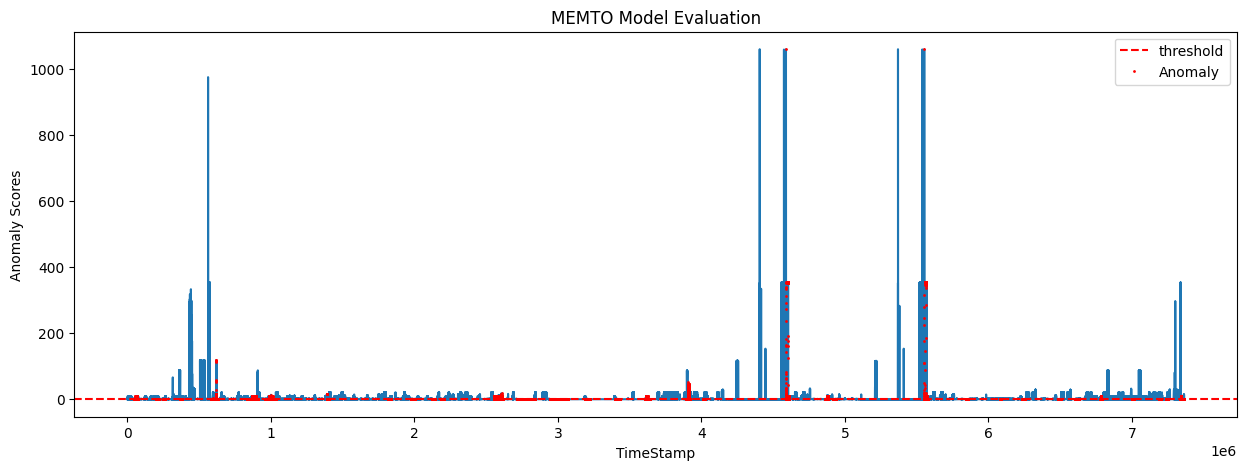

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(test_energy)
plt.axhline(y=threshold, color='r', linestyle='--', label='threshold')
anomaly_indices = np.where(gt == 1)[0]
plt.plot(np.arange(len(test_energy))[anomaly_indices], test_energy[anomaly_indices], 'r.', markersize=2,
         label='Anomaly')
plt.title('MEMTO Model Evaluation')
plt.xlabel('TimeStamp')
plt.ylabel('Anomaly Scores')
plt.legend()